In [1]:
import numpy as np
from robopianist import suite
from robopianist import music
from mujoco_utils import composer_utils
from robopianist.suite.tasks import piano_with_shadow_hands 
import note_seq
import pretty_midi
!export BOKEH_PY_LOG_LEVEL=critical

/home/ubuntu/miniconda3/envs/pianist/lib/python3.10/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/ubuntu/miniconda3/envs/pianist/lib/python3.10/site-packages/bokeh/core/property/primitive.py:37: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  bokeh_bool_types += (np.bool8,)


In [2]:
!pip install --upgrade bokeh==2.4.3 

In [3]:
import sys  
sys.path.append("/home/ubuntu/curriculum/robopianist-cl/utils") 
from utils import get_overlapping_chunks_with_auto_overlap

etude_melodies = ["FrenchSuiteNo1Allemande", "FrenchSuiteNo5Sarabande", "PianoSonataD8451StMov", "PartitaNo26", 
                  "WaltzOp64No1", "BagatelleOp3No4", "KreislerianaOp16No8", "FrenchSuiteNo5Gavotte", 
                  "PianoSonataNo232NdMov", "GolliwoggsCakewalk", "PianoSonataNo21StMov", "PianoSonataK279InCMajor1StMov"]

separated_chunks = []
all_chunks = []
chunk_duration = 5

for melody in etude_melodies:
    midi = music.load(melody)
    chunks = get_overlapping_chunks_with_auto_overlap(midi, chunk_duration)
    all_chunks.extend(chunks)
    separated_chunks.append(chunks)

In [4]:
import math

def chunk_to_matrix(all_chunks):
    chunk_activations = []
    for chunk in all_chunks:
        # 128: determined range of pitch
        # 101: number of 0.05 second intervals for a 5 second chunk
        binary_pitch_matrix = np.zeros((128, 101))
        for note in list(chunk.seq.notes):
            #activates from the leftmost to the rightmost bin that the note is in
            round_start = int(note.start_time * 20)
            round_end = math.ceil(note.end_time * 20)
            for i in range(round_start, round_end):
                binary_pitch_matrix[note.pitch][i] = 1
        # appends the row-major flattened matrix to the list of all matricies
        chunk_activations.append(binary_pitch_matrix.ravel()) 
    chunk_activations = np.array(chunk_activations)
    return chunk_activations

In [5]:
all_chunk_activations = chunk_to_matrix(all_chunks)

In [6]:
sep_chunk_activations = []
for melody_chunks in separated_chunks:
    matrix_act = chunk_to_matrix(melody_chunks)
    sep_chunk_activations.append(matrix_act)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_fit = scaler.fit(all_chunk_activations)
standardized_data = standardized_fit.transform(all_chunk_activations)
pca = PCA(n_components=2)
pca.fit(standardized_data)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

reduced_data = pca.transform(standardized_data)

Explained Variance Ratio: [0.035536   0.03282189]


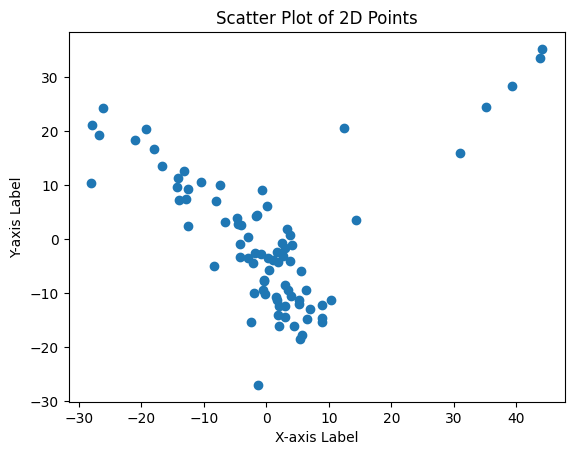

In [8]:
import matplotlib.pyplot as plt

x = [point[0] for point in reduced_data]
y = [point[1] for point in reduced_data]

plt.scatter(x, y)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot of 2D Points')

plt.show()

In [11]:
sep_reduced_data = []
for activation in sep_chunk_activations:
    #alternatively standardized by the scalar fit to all the data, not the data for individual songs
    #standardized_fit = scaler.fit(all_chunk_activations)
    standardized_fit = scaler.fit(activation)
    standardized_data = standardized_fit.transform(activation)
    pca = PCA(n_components=2)
    pca.fit(standardized_data)

    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance)

    reduced_data = pca.transform(standardized_data)
    sep_reduced_data.append(reduced_data)

Explained Variance Ratio: [0.2429414  0.22592316]
Explained Variance Ratio: [0.15530405 0.13682565]
Explained Variance Ratio: [0.18181349 0.15777816]
Explained Variance Ratio: [0.28240716 0.26647653]
Explained Variance Ratio: [0.13465902 0.13348879]
Explained Variance Ratio: [0.26007545 0.21634908]
Explained Variance Ratio: [0.33262609 0.2465355 ]
Explained Variance Ratio: [0.13949056 0.13280743]
Explained Variance Ratio: [0.40461041 0.31768949]
Explained Variance Ratio: [0.28217313 0.25482367]
Explained Variance Ratio: [0.39331867 0.33167548]
Explained Variance Ratio: [0.22405205 0.21113704]


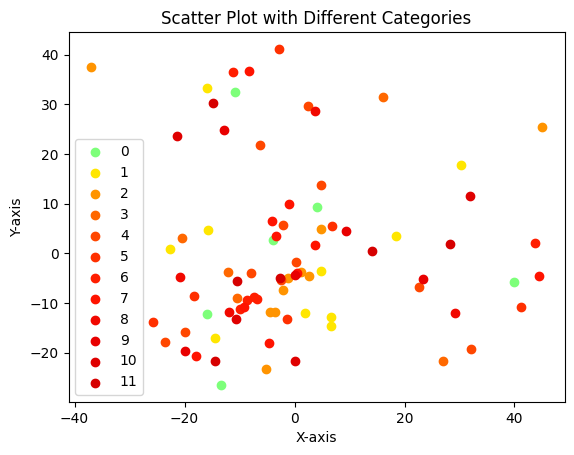

In [12]:
categories = {}
colors = {}

for i in range(len(sep_reduced_data)):
    x = [point[0] for point in sep_reduced_data[i]]
    y = [point[1] for point in sep_reduced_data[i]]
    
    categories[i] = {'x': x, 'y': y}
    colors[i] = plt.cm.jet(len(categories) / (len(categories) + 1))

for category, points in categories.items():
    plt.scatter(points['x'], points['y'], label=category, color=colors[category])

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Scatter Plot with Different Categories')

plt.show()